In [1]:
!pip install datasets==2.9.0

from datasets import load_dataset

In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [83]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize = (16,6))

    plt.subplot(1,2,1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'),label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label = 'Validation')
    plt.ylim([0.,1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.subplot(1,2,2)
    plt.plot(range(0,epochs_trained),h.history.get('loss'), label = 'Training')
    plt.plot(range(0,epochs_trained), h.history.get('val_loss'), label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize = 'true')
    plt.figure(figsize = (8,8))
    sp=plt.subplot(1,1,1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0,6)),labels=classes)
    plt.yticks(list(range(0,6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
print('Using Tensorflow version', tf.__version__)

Using Tensorflow version 2.11.0


In [37]:
dataset = load_dataset('emotion')

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/hp/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [39]:
train =  dataset['train']
test = dataset['test']
val = dataset['validation']

In [40]:
def get_tweet(data):
    tweets = [x['text'] for x in train]
    labels = [x['label'] for x in train]
    return tweets, labels

In [41]:
tweets, labels = get_tweet(train)

In [42]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

In [43]:
tweets

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [45]:
tokenizer = Tokenizer(num_words=10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [46]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

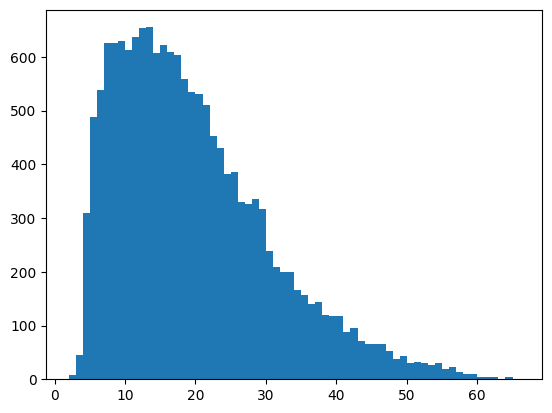

In [47]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [48]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=maxlen)
    return padded

In [50]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [51]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [52]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


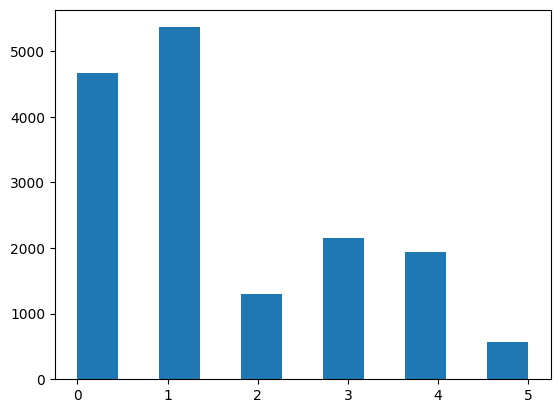

In [53]:
plt.hist(labels, bins=11)
plt.show()

In [54]:
label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
index_to_class = {label: label_mapping[label] for label in classes}

In [55]:
index_to_class

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [56]:
class_to_index = {index_to_class[label]: label for label in index_to_class}

In [57]:
class_to_index

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [58]:
# Instead of a lambda function proposed in the guided project, we just need to convert from a list to a numpy array
train_labels = np.array(labels)

In [59]:
train_labels[0]

0

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [62]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = np.array(val_labels)

In [63]:
val_tweets[0], val_labels[0]

('i didnt feel humiliated', 0)

In [64]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 24s 39ms/step - loss: 1.3469 - accuracy: 0.4719 - val_loss: 0.8236 - val_accuracy: 0.7082
Epoch 2/20
500/500 [==============================] - 19s 38ms/step - loss: 0.5961 - accuracy: 0.7904 - val_loss: 0.3787 - val_accuracy: 0.8777
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.3475 - accuracy: 0.8843 - val_loss: 0.2804 - val_accuracy: 0.9096
Epoch 4/20
500/500 [==============================] - 24s 49ms/step - loss: 0.2383 - accuracy: 0.9213 - val_loss: 0.1809 - val_accuracy: 0.9399
Epoch 5/20
500/500 [==============================] - 23s 47ms/step - loss: 0.1615 - accuracy: 0.9484 - val_loss: 0.1249 - val_accuracy: 0.9605
Epoch 6/20
500/500 [==============================] - 20s 41ms/step - loss: 0.1310 - accuracy: 0.9591 - val_loss: 0.0951 - val_accuracy: 0.9727
Epoch 7/20
500/500 [==============================] - 20s 39ms/step - loss: 0.0986 - accuracy: 0.9691 - val_loss: 0.0834 - val_accuracy:

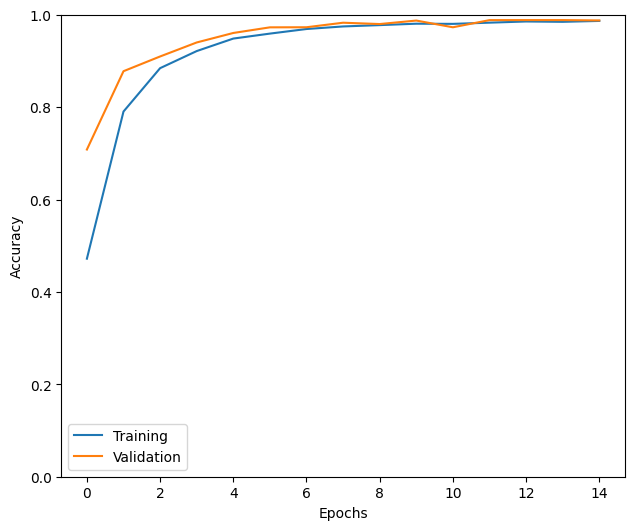

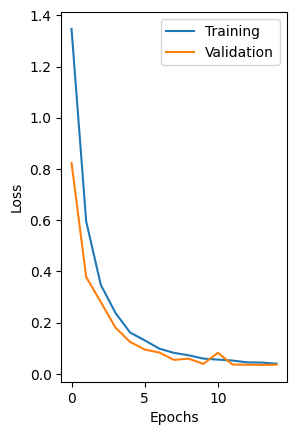

In [73]:
show_history(h)

In [75]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = np.array(test_labels)

In [76]:
_ = model.evaluate(test_sequences, test_labels)

500/500 [==============================] - 9s 19ms/step - loss: 0.0359 - accuracy: 0.9876


In [79]:
i = random.randint(0, len(test_labels) - 1)

print(f'Sentence: {test_tweets[i]}')
print(f'Emotion: {index_to_class[test_labels[i]]}')

p = np.argmax(model.predict(np.expand_dims(test_sequences[i], axis=0)), axis=-1)[0]

print(f'Predicted Emotion: {index_to_class.get(p)}')

Sentence: i witness what i feel helpless to change i take up my arms my heart and my pen and i write
Emotion: sadness
1/1 [==============================] - 0s 43ms/step
Predicted Emotion: sadness


In [80]:
preds = np.argmax(model.predict(test_sequences), axis=-1)
preds.shape, test_labels.shape

500/500 [==============================] - 8s 17ms/step


((16000,), (16000,))

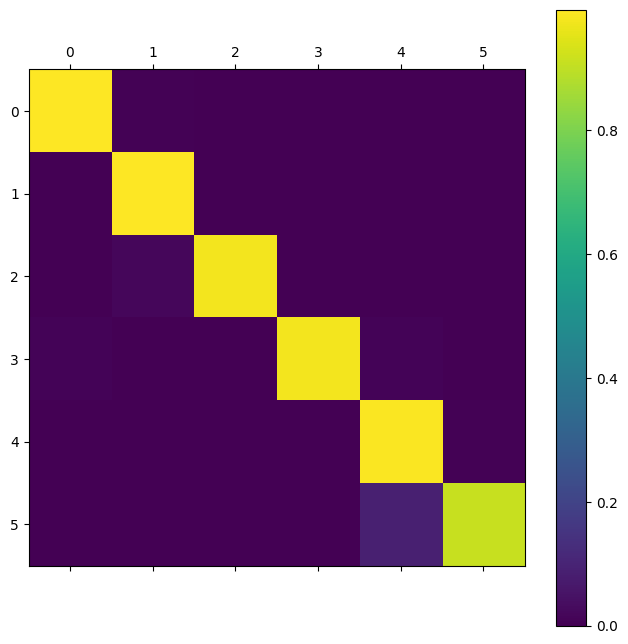

In [84]:
show_confusion_matrix(test_labels, preds, list(classes))